In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from sklearn.decomposition import PCA
import pandas as pd
import datetime
import pickle
import hdbscan

In [2]:
task_name = "CDDM"
RNNs_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name)

In [3]:
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "trained_RNNs", task_name)):
    if (folder == '.DS_Store'):
        pass
    else:
        if "relu" in folder:
            RNNs.append(folder)

In [4]:
names = []
scores = []
Ns = []
lmbdos = []
lmbdrs = []
lrs = []
activations = []
tags = []
maxiters = []
dates = []
for folder in RNNs:
    day = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%d')
    month = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%m')
    year = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%Y')
    if (float(month) >= 4) and (float(day) >=23):
        files = os.listdir(os.path.join(RNNs_path, folder))
        config_file = None
        for file in files:
            if "config" in file:
                config_file = file
        config_data = json.load(open(os.path.join(RNNs_path, folder, config_file), "rb+"))
        score = np.round(float(config_file.split("_")[0]), 7)
        activation = config_data["activation"]
        N = config_data["N"]
        lmbdo = config_data["lambda_orth"]
        lmbdr = config_data["lambda_r"]
        lr=config_data["lr"]
        maxiter=config_data["max_iter"]
        extra_info = f"{task_name};{activation};N={N};lmbdo={lmbdo};lmbdr={lmbdr};lr={lr};maxiter={maxiter}"
        name = f"{score}_{extra_info}"
        tag = config_data["tag"]
        names.append(name)
        scores.append(score)
        Ns.append(N)
        lmbdos.append(lmbdo)
        lmbdrs.append(lmbdr)
        lrs.append(lr)
        tags.append(tag)
        activations.append(activation)
        maxiters.append(maxiter)
        dates.append(f"{day}/{month}/{year}")

In [5]:
df = pd.DataFrame({"name" : names, "scores" : scores, "N" : Ns, "date": dates, "activation": activations, "lmbdo" : lmbdos, "lmbdr": lmbdrs, "lr" : lrs, "maxiter" : maxiters})

In [6]:
# additional filtering
# df = df[df['lr'] == 0.005]
df = df[df['maxiter'] == 3000]

In [7]:
pd.set_option('display.max_rows', None)
df.sort_values("scores")

,name,scores,N,date,activation,lmbdo,lmbdr,lr,maxiter
57,0.0070617_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;...,0.007062,90,24/04/2023,relu,0.3,0.05,0.002,3000
52,0.0070979_CDDM;relu;N=93;lmbdo=0.3;lmbdr=0.05;...,0.007098,93,24/04/2023,relu,0.3,0.05,0.002,3000
2,0.007163_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;l...,0.007163,90,24/04/2023,relu,0.3,0.05,0.002,3000
58,0.0071706_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;...,0.007171,95,24/04/2023,relu,0.3,0.05,0.002,3000
1,0.0071953_CDDM;relu;N=89;lmbdo=0.3;lmbdr=0.05;...,0.007195,89,24/04/2023,relu,0.3,0.05,0.002,3000
32,0.0071971_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;...,0.007197,95,24/04/2023,relu,0.3,0.05,0.002,3000
21,0.0072101_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.05;...,0.007210,87,24/04/2023,relu,0.3,0.05,0.002,3000
0,0.0072113_CDDM;relu;N=86;lmbdo=0.3;lmbdr=0.05;...,0.007211,86,24/04/2023,relu,0.3,0.05,0.002,3000
39,0.0072446_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;...,0.007245,97,24/04/2023,relu,0.3,0.05,0.002,3000
72,0.0072573_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.007257,99,24/04/2023,relu,0.3,0.05,0.002,3000


In [8]:
top_RNNs = df.sort_values("scores")["name"].tolist()[:50]

In [9]:
top_RNNs

['0.0070617_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0070979_CDDM;relu;N=93;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.007163_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0071706_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0071953_CDDM;relu;N=89;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0071971_CDDM;relu;N=95;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072101_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072113_CDDM;relu;N=86;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072446_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072573_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072886_CDDM;relu;N=94;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.007289_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0072974_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3000',
 '0.0073205_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.05;lr=0.002;maxiter=3

In [10]:
num_rnn = 0
RNN_subfolder = top_RNNs[num_rnn]
RNN_score = float(top_RNNs[num_rnn].split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name, RNN_subfolder)
os.listdir(RNN_path)

['0.0070617_config.json',
 '0.0070617_LA_RHS.png',
 '0.0070617_params_CDDM.json',
 '0.0070617_psycho_data.json',
 '0.0070617_LA_3D.png',
 '0.0070617_psychometric_data.png',
 '0.0070617_random_trials.png',
 '0.0070617_train&valid_loss.png',
 '0.0070617_fp_data.json',
 '0.0070617_LA_data.pkl']

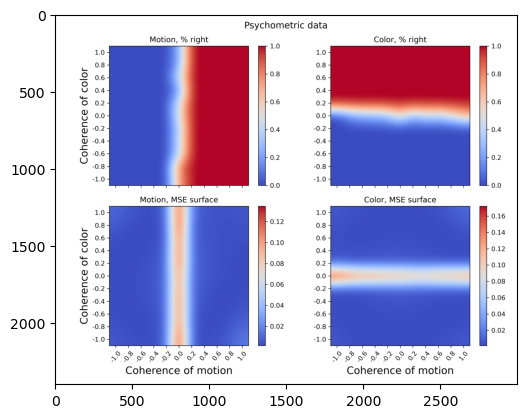

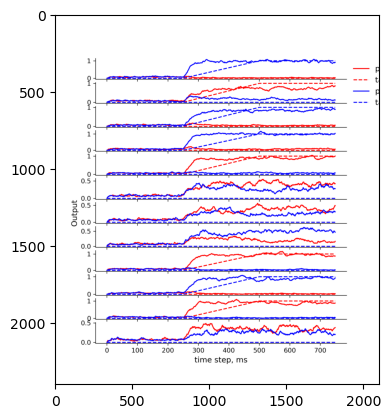

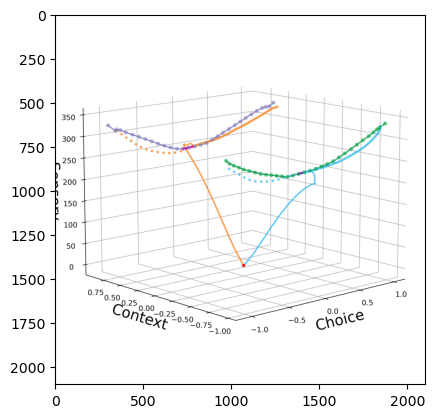

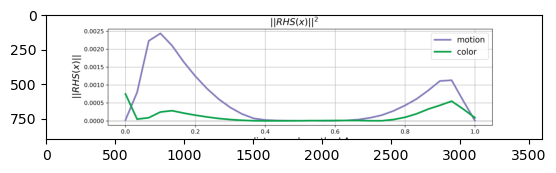

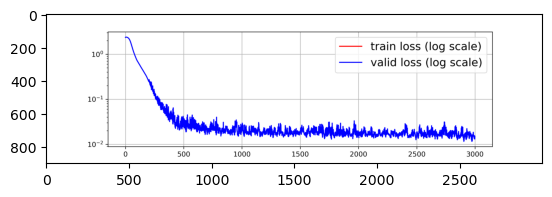

In [11]:
img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_psychometric_data.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_random_trials.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_3D.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_RHS.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_train&valid_loss.png"), 'rb+'))
plt.imshow(img)
plt.show()


In [12]:
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

In [13]:
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

if activation == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation == 'tanh':
    activation_RNN = torch.tanh
elif activation == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))

seed: 761845


In [14]:
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]
dt = RNN_config_file["dt"]
tau = RNN_config_file["tau"]

# Decoding variables

In [15]:
task_params_train = deepcopy(task_params)
task_params_train["coherences"] = [-0.8, -0.4, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.4, 0.8]
k = len(task_params_train["coherences"])**2
# task_params_train["coherences"] = [-0.2, -0.1, -0.05, -0.025, 0, 0.025, 0.05, 0.1, 0.2]
task_train = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_train)
input_batch_train, target_batch_train, conditions_batch_train = task_train.get_batch()
input_batch_train_0 = deepcopy(input_batch_train)
input_batch_train_0[:2, ...] = 0
input_batch_train_1 = deepcopy(input_batch_train)
input_batch_train_1[:2, ...] = 1
input_batch_train = np.concatenate([input_batch_train[:, :, :k], input_batch_train_0[:, :, :k], input_batch_train_1[:, :, :k],
                             input_batch_train[:, :, k:], input_batch_train_0[:, :, k:], input_batch_train_1[:, :, k:]], axis=2)
n_trials = input_batch_train.shape[-1]

RNN_train = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN_train.set_params(RNN_params)

RNN_train.sigma_rec = RNN_train.sigma_inp = torch.tensor(0, device=RNN_train.device)
y_train, predicted_output_rnn_train = RNN_train(torch.from_numpy(input_batch_train.astype("float32")))
Y_train = np.hstack([y_train.detach().numpy()[:, :, i] for i in range(y_train.shape[-1])])

Using cpu for RNN!


/Users/tolmach/Documents/GitHub/rnn_coach/jupyter/../../rnn_coach/src/RNN_torch.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tnsr = torch.normal(torch.tensor(mean).to(device), torch.tensor(std).to(device),


In [16]:
task_params_valid = deepcopy(task_params)
# task_params_valid["coherences"] = [-0.8, -0.4, -0.15, 0.15, 0.4, 0.8]
task_params_valid["coherences"] = [-1, -0.75, -0.6, -0.3, -0.15, 0.15, 0.3, 0.6, 0.75, 1.0]
task_valid = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_valid)
input_batch_valid, target_batch_valid, conditions_batch_valid = task_valid.get_batch()
# input_batch_valid[:2, ...] = 1 #
n_trials = len(conditions_batch_valid)

RNN_valid = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN_valid.set_params(RNN_params)

RNN_valid.sigma_rec = RNN_valid.sigma_inp = torch.tensor(0, device=RNN_valid.device)
y_valid, predicted_output_rnn_valid = RNN_valid(torch.from_numpy(input_batch_valid.astype("float32")))
Y_valid = np.hstack([y_valid.detach().numpy()[:, :, i] for i in range(y_valid.shape[-1])])

Using cpu for RNN!


In [17]:
# def variable_fun(input_batch):
#     T = np.hstack([input_batch[:, :, i] for i in range(input_batch.shape[-1])])
#     return ((T[3, :] - 0.4)**2 + (T[4, :] - 0.4)**2)**0.5

def variable_fun(input_batch):
    T = np.hstack([input_batch[:, :, i] for i in range(input_batch.shape[-1])])
    return (T[2, :])

# def variable_fun(input_batch): # suppressed representation
#     k = input_batch.shape[-1]//2
#     T1 = np.hstack([input_batch[:, :, i] for i in range(k)])
#     T2 = np.hstack([0 * input_batch[:, :, i + k] for i in range(k)])
#     T = np.hstack([T1, T2])
#     return (T[2, :] - T[3, :])

T = variable_fun(input_batch_train)
T_valid = variable_fun(input_batch_valid)
Target_bs = T.reshape(-1, 750)
Target_bs_valid = T_valid.reshape(-1, 750)

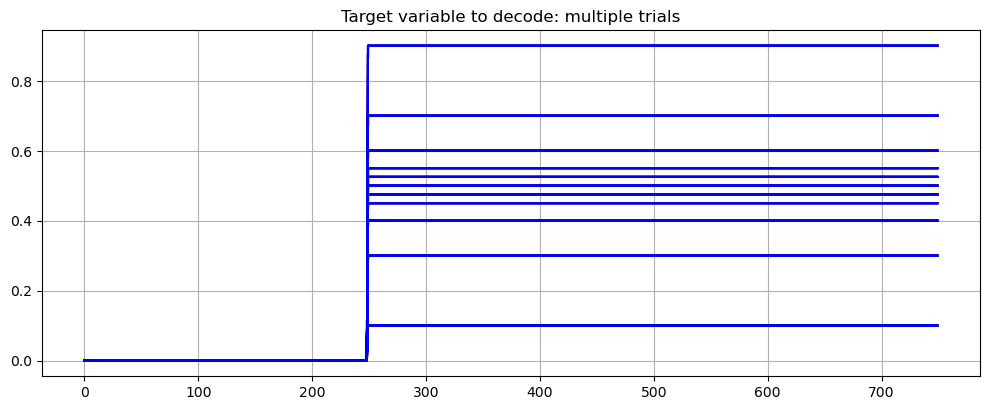

In [18]:
k = len(task_params_train["coherences"])**2
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(Target_bs[:k, :].T, color='r', linestyle='-', alpha=0.1, label = 'target in motion context')
ax.plot(Target_bs[k:, :].T, color='b', linestyle='-', alpha=0.1, label = 'target in color context')
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('Target variable to decode: multiple trials')
ax.grid(True)
plt.show()

In [19]:
regularization = 100
a = lsqr(Y_train.T, T, damp=regularization)[0]

Decoded_bs = (a @ Y_train).reshape(-1, 750)
Decoded_bs_valid = (a @ Y_valid).reshape(-1, 750)

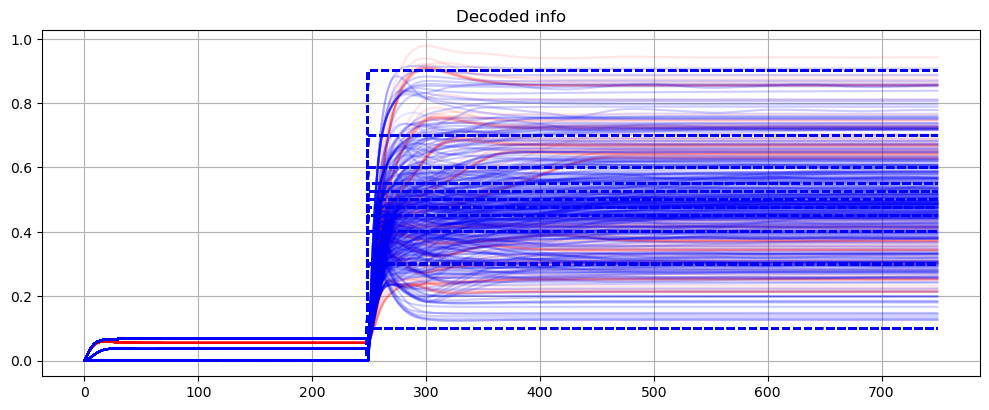

In [20]:
k = len(task_params_train["coherences"])**2
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(Decoded_bs[:k, :].T, color='r', alpha=0.1, label = 'relevant')
ax.plot(Decoded_bs[k:, :].T, color='b', alpha=0.1, label = 'irrelevant')
ax.plot(Target_bs[:k, :].T, color='r', linestyle='--', alpha=1, label = 'target')
ax.plot(Target_bs[k:, :].T, color='b', linestyle='--', alpha=1, label = 'target')
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('Decoded info')
ax.grid(True)
plt.show()

In [21]:
target = Target_bs
prediction = Decoded_bs
R2_0 = 1 - np.mean((target - prediction)**2) / np.mean((target - np.mean(target, axis = 0))**2)
print(R2_0)

0.5970590792879698


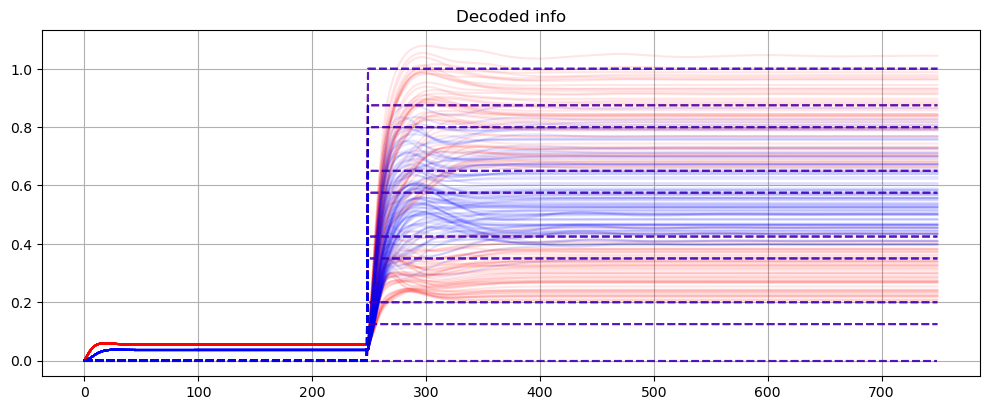

In [22]:
k = len(task_params_valid["coherences"])**2
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(Decoded_bs_valid[:k, :].T, color='r', alpha=0.1, label = 'relevant')
ax.plot(Decoded_bs_valid[k:, :].T, color='b', alpha=0.1, label = 'irrelevant')
ax.plot(Target_bs_valid[:k, :].T, color='r', linestyle='--', alpha=0.1, label = 'target')
ax.plot(Target_bs_valid[k:, :].T, color='b', linestyle='--', alpha=0.1, label = 'target')
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('Decoded info')
ax.grid(True)
plt.show()

In [23]:
target = Target_bs_valid
prediction = Decoded_bs_valid
R2_0 = 1 - np.mean((target - prediction)**2) / np.mean((target - np.mean(target, axis = 0))**2)
print(R2_0)

0.6389784288029356


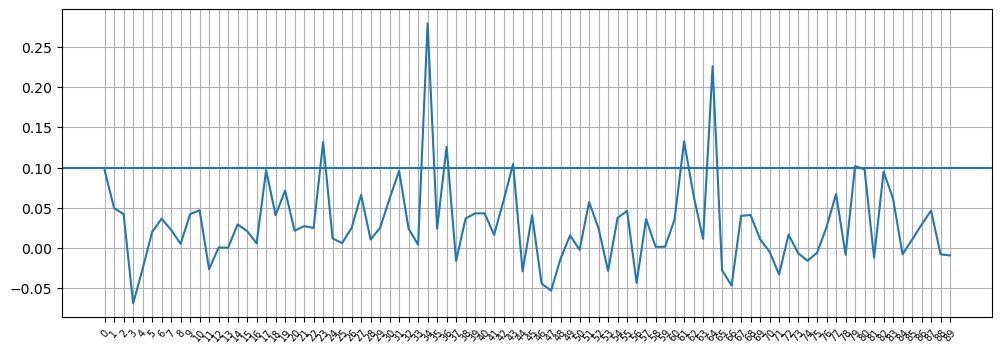

In [24]:
figure = plt.figure(figsize = (12, 4))
plt.plot(a)
plt.xticks(np.arange(len(a)), rotation = 50, fontsize = 7)
plt.grid(True)
plt.axhline(0.1)
plt.show()

# plotting individual neuron traces

In [25]:
task_params["coherences"] = [-0.8, 0, 0.8]
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)

RNN = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN.set_params(RNN_params)

RNN.sigma_rec = RNN.sigma_inp = torch.tensor(0, device=RNN.device)
y, predicted_output_rnn = RNN(torch.from_numpy(input_batch.astype("float32")))
# Y_valid = np.hstack([y.detach().numpy()[:, :, i] for i in range(y.shape[-1])])

Using cpu for RNN!


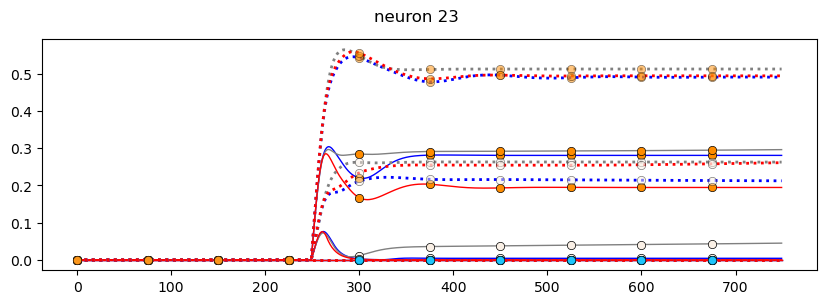

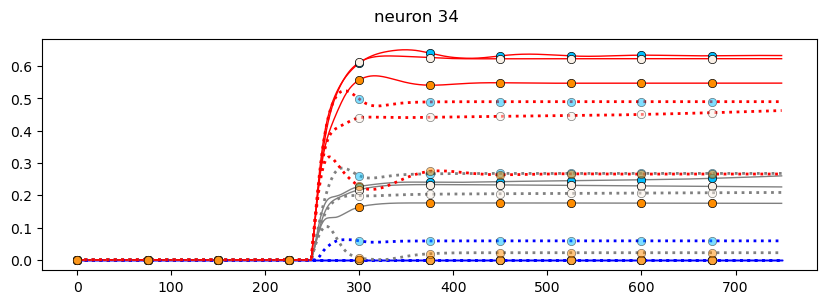

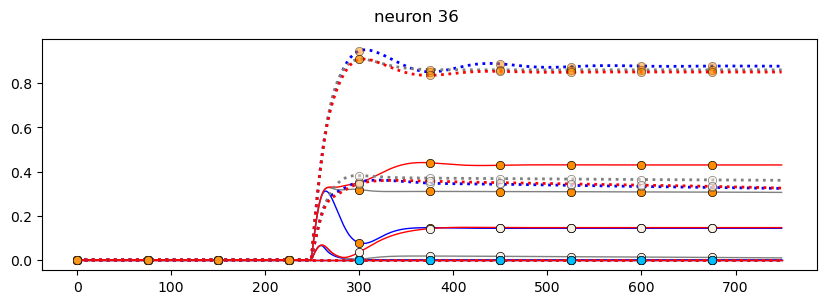

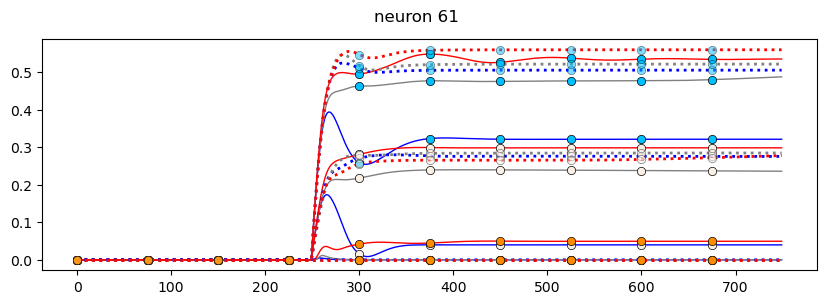

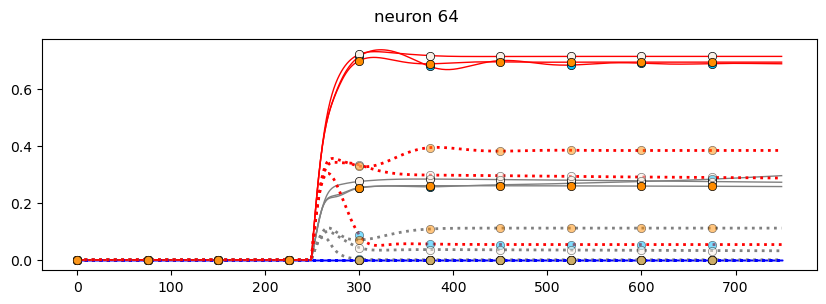

In [26]:
from matplotlib.colors import hsv_to_rgb
traces = y.detach().numpy()
num_steps = traces.shape[1]
circle_every = num_steps//10
for num_nrn in [23, 34, 36, 61, 64]:
    fig = plt.figure(figsize = (10, 3))
    plt.suptitle(f"neuron {num_nrn}")
    for i in range(traces.shape[-1]):
        motion_coh = conditions_batch[i]["motion_coh"]
        color_coh = conditions_batch[i]["color_coh"]
        context = conditions_batch[i]["context"]
        match motion_coh:
            case -0.8: color_line = 'b'; 
            case 0: color_line = 'gray'
            case 0.8: color_line = 'r'
        match color_coh:
            case -0.8: color_circle = 'deepskyblue'
            case 0: color_circle = 'linen'
            case 0.8: color_circle = 'darkorange'
        match context:
            case "motion": linestyle='-'; alpha = 1; linewidth = 1
            case "color": linestyle = ':'; alpha = 0.5; linewidth = 2
        if context == 'motion':
            label=f'({motion_coh},{color_coh})'
        else:
            label = None
        plt.plot(traces[num_nrn, :, i], color = color_line, linestyle=linestyle, linewidth=linewidth, label=label)
        plt.scatter(np.arange(num_steps)[::circle_every], traces[num_nrn, ::circle_every, i], facecolors=color_circle, edgecolors='k', linewidth=0.5, alpha = alpha, zorder=3)
#     plt.legend(loc = 2, fontsize = 8)
    plt.show()

In [27]:
# ctxm = [9]
# ctxc = [5]
# ctx_mR =  [0, 8, 14, 24]
# ctx_mL =  [12, 17]
# ctx_cR = [4, 10, 23]
# ctx_cL = [3, 7, 13]
# OurR = []
# OutL = [19, 22]
# mL = [20]
# cR = [2]
# Outliers = [1, 6, 18, 21]


# indices = ctxm + ctxc + ctx_mR + ctx_mL + ctx_cR + ctx_cL + OurR + OutL + mL + cR + Outliers

In [28]:
# from matplotlib.colors import hsv_to_rgb
# num_steps = traces.shape[1]
# circle_every = num_steps//10
# for num_nrn in ctx_cR:
#     fig = plt.figure(figsize = (10, 3))
#     plt.suptitle(f"neuron {num_nrn}")
# #     for i in range(traces.shape[-1]//2, traces.shape[-1]):
#     for i in range(traces.shape[-1]):
#         motion_coh = conditions_batch[i]["motion_coh"]
#         color_coh = conditions_batch[i]["color_coh"]
#         context = conditions_batch[i]["context"]
#         match motion_coh:
#             case -0.8: color_line = 'b'; 
#             case 0: color_line = 'gray'
#             case 0.8: color_line = 'r'
#         match color_coh:
#             case -0.8: color_circle = 'deepskyblue'
#             case 0: color_circle = 'linen'
#             case 0.8: color_circle = 'darkorange'
#         match context:
#             case "motion": linestyle='-'; alpha = 1; linewidth = 1
#             case "color": linestyle = ':'; alpha = 0.5; linewidth = 2
#         if context == 'motion':
#             label=f'({motion_coh},{color_coh})'
#         else:
#             label = None
#         plt.plot(traces[num_nrn, :, i], color = color_line, linestyle=linestyle, linewidth=linewidth, label=label)
#         plt.scatter(np.arange(num_steps)[::circle_every], traces[num_nrn, ::circle_every, i], facecolors=color_circle, edgecolors='k', linewidth=0.5, alpha = alpha, zorder=3)
# #     plt.legend(loc = 2, fontsize = 8)
#     plt.show()

In [29]:
# # sorting out W_rec
# W_rec_sorted = deepcopy(W_rec)
# W_rec_sorted = W_rec_sorted[:, indices]
# W_rec_sorted = W_rec_sorted[indices, :]

In [30]:
# mat = W_rec_sorted
# fig, ax = plt.subplots(1, 1, figsize=(12,12))
# plt.imshow(mat, cmap='coolwarm', vmin = -1, vmax = 1)
# for (i, j), z in np.ndenumerate(mat):
#     if np.abs(z) > 0.05:
#         ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
# ax.set_xticks(np.arange(22), labels=indices)
# ax.set_yticks(np.arange(22), labels=indices)
# # ax.set_xticklabels(indices)
# # ax.set_yticklabels(indices)
# plt.show()

In [31]:
# mat = W_out
# fig, ax = plt.subplots(1, 1, figsize=(12,12))
# plt.imshow(mat, cmap='coolwarm', vmin = -1, vmax = 1)
# for (i, j), z in np.ndenumerate(mat):
#     if np.abs(z) > 0.05:
#         ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
# ax.set_xticks(np.arange(25))
# plt.show()

In [32]:
# mat = W_out[:, indices]
# fig, ax = plt.subplots(1, 1, figsize=(12,12))
# plt.imshow(mat, cmap='coolwarm', vmin = -1, vmax = 1)
# for (i, j), z in np.ndenumerate(mat):
#     if np.abs(z) > 0.05:
#         ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
# ax.set_xticks(np.arange(22), labels=indices)
# plt.show()

In [33]:
# mat = W_inp[indices, :].T
# fig, ax = plt.subplots(1, 1, figsize=(12,12))
# plt.imshow(mat, cmap='coolwarm', vmin = -1, vmax = 1)
# for (i, j), z in np.ndenumerate(mat):
#     if np.abs(z) > 0.05:
#         ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
# ax.set_xticks(np.arange(22), labels=indices)
# plt.show()

# clustering neurons

In [35]:
n_t = traces.shape[1]
features1 = np.mean(traces[:, :n_t//3, :], axis = 1)
features2 = np.mean(traces[:, n_t//3:2*n_t//3, :], axis = 1)
features3 = np.mean(traces[:, 2*n_t//3:, :], axis = 1)
features4 = np.mean(W_rec, axis = 1).reshape(-1, 1)
features5 = np.mean(W_rec, axis = 0).reshape(-1, 1)

feature_mat = np.hstack([eval(f"features{i}") for i in range(1, 6)])

In [42]:
pca = PCA(n_components=5)
pca.fit(feature_mat)

PCA(n_components=5)

In [45]:
pca.explained_variance_ratio_

array([0.3963672 , 0.21529881, 0.1605269 , 0.15386714, 0.02769583])

In [47]:
Vis_features = feature_mat @ pca.components_.T

<IPython.core.display.Javascript object>


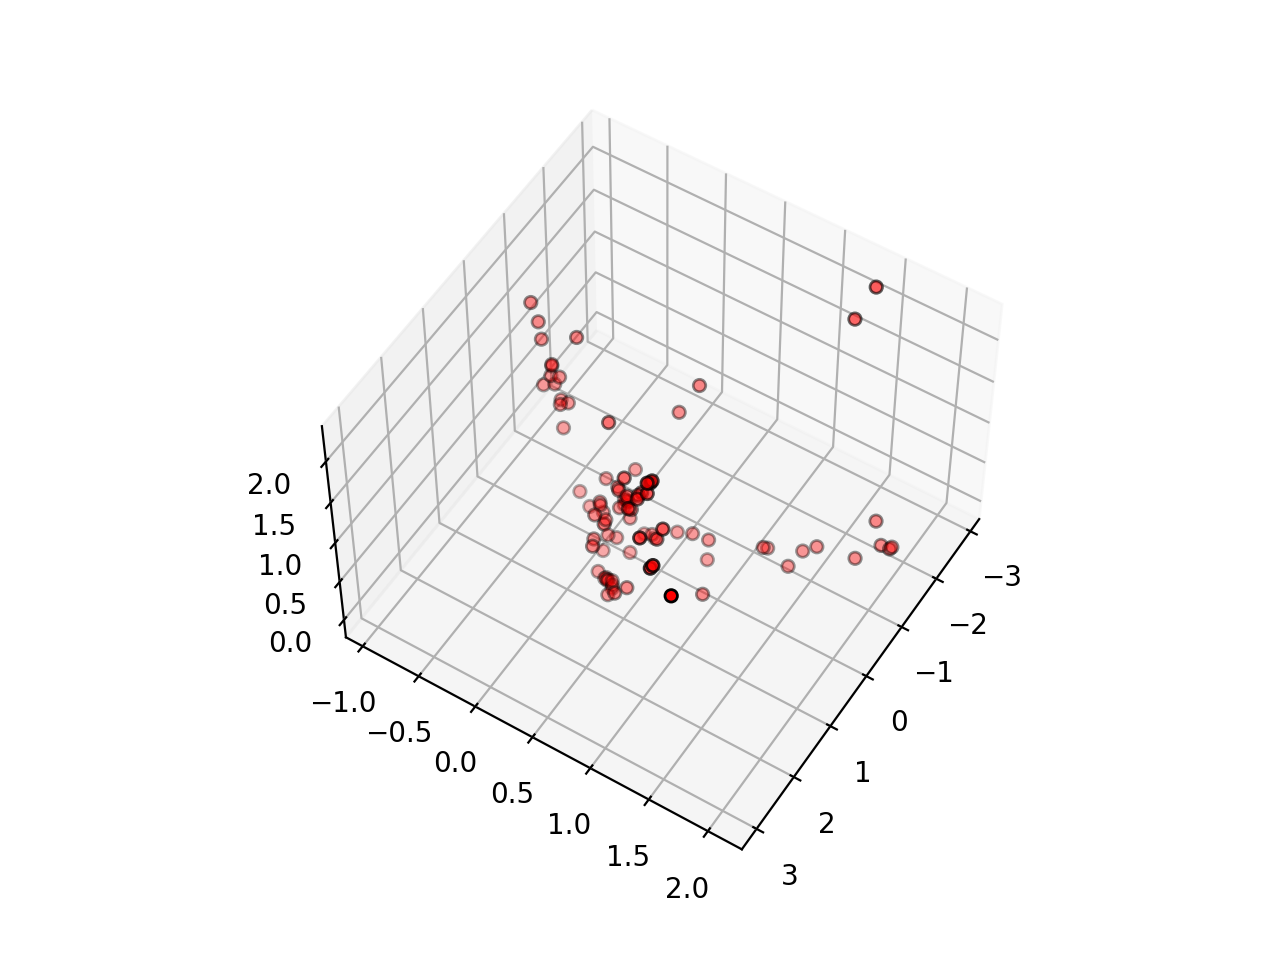

In [60]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Vis_features[:, 0], Vis_features[:, 1], Vis_features[:, 2], c='r', marker='o', edgecolor='k')
plt.show()